   pertSize  reactionTime  initialResponse  subID  blockNo  prevSize  \
0       100      1.718003               -1      1        1         0   
1        25      1.961003               -1      1        1       100   
2       -50      2.397006                1      1        1        25   
3      -200      3.371999                1      1        1       -50   
4       150      2.364999               -1      1        1      -200   

   leftResponse  rightResponse  noResponse  nullTrials  correctResponses  \
0             1              0           0           0                 1   
1             1              0           0           0                 1   
2             0              1           0           0                 1   
3             0              1           0           0                 1   
4             1              0           0           0                 1   

   incorrectResponses  
0                   0  
1                   0  
2                   0  
3             

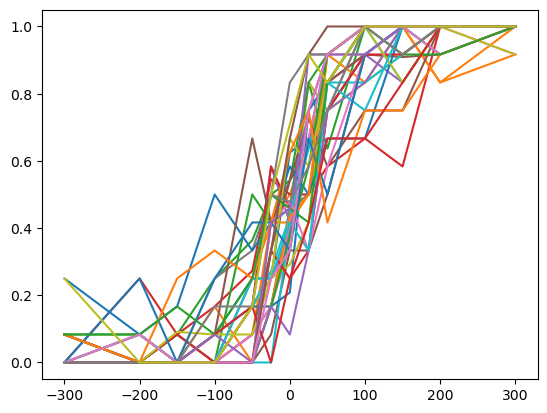

<Figure size 640x480 with 0 Axes>

In [5]:
#Load data in detailed form by running load_data.py script
from utils import *
data = load_data()

True:  5 50 1 0.5
Fitted:  8.926223391939502 -48.98320807803696 0.9161239760815332 0.4912579030229621


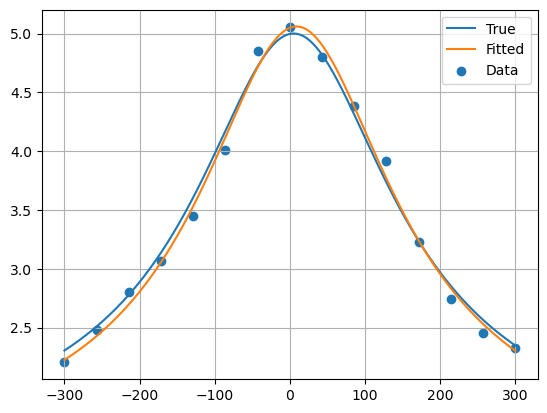

In [6]:
# Test functionality from utils.py
import numpy as np
import matplotlib.pyplot as plt

b=50
a=5
#linspace from -400 to 400 in 1 increments
dv = np.linspace(-300, 300, 100000)
p = true_p(dv, a, b)
lo = log_odds(dv, a, b)
lp = log_p(lo)
#Plot
#plt.plot(dv, p)
#plt.plot(dv, np.log(p))
#plt.grid()

#RT fitting test
N_reps = 10
dv2 = np.linspace(-300, 300, 15)
t = np.zeros((N_reps, len(dv2)))
t_nd = 1
noise_std = 0.5
for i in range(N_reps):
    t[i] = exp_RT(t_nd, noise_std, a, b, dv2) + np.random.randn(len(dv2))*.3

#Fit RT
ftnd, fn, fa, fb = fit_RT(np.mean(t,axis=0),dv2)

mt = exp_RT(t_nd, noise_std, a, b, dv) #True
ft = exp_RT(ftnd, fn, fa, fb, dv) #Fitted
print('True: ', a, b, t_nd, noise_std)
print('Fitted: ', fa, fb, ftnd, fn)
plt.figure()
plt.plot(dv, mt)
plt.plot(dv, ft)
plt.scatter(dv2, np.mean(t,axis=0))
plt.grid()
plt.legend(['True', 'Fitted', 'Data'])

# DDM fitting to reaction times (RTs)

## Model fitting

In [7]:
#Use reaction times to fit DDM parameters
n_subs = data['subID'].nunique()
jnd_RT = []
pse_RT = []
#Generate structure to save parameter estimates
params_RT = np.zeros((n_subs, 4))
params_RT_DR = np.zeros((n_subs, 5))
params_noDR = np.zeros((n_subs, 3))
params_DR = np.zeros((n_subs, 3))
logL = np.zeros(n_subs)
logL_DR = np.zeros(n_subs)
logL_noDR_acc = np.zeros(n_subs)
logL_DR_acc = np.zeros(n_subs)
#Create a new dataframe supressing noResponse trials
df_excludingNR = data[data['noResponse'] == 0]
#for sub in df_excludingNR['subID'].unique():
for sub in df_excludingNR['subID'].unique():
    t = df_excludingNR[df_excludingNR['subID'] == sub].groupby(['pertSize'])['reactionTime'].mean()
    tm = df_excludingNR[df_excludingNR['subID'] == sub].groupby(['pertSize'])['reactionTime'].median()
    ch = df_excludingNR[df_excludingNR['subID'] == sub]['leftResponse']
    dv2 = df_excludingNR[df_excludingNR['subID'] == sub]['pertSize']
    dv = t.index.to_numpy()
    dvm = tm.index.to_numpy()
    n_reps = df_excludingNR[df_excludingNR['subID'] == sub].groupby(['pertSize'])['reactionTime'].count() #Counting repetitions
    params_init = [-2, 0.5, 0, 100]
    t_nd, noise_std, a, b = fit_RT(t, dv, bounds = ((-3,3), (0.001, 1), (-100, 100), (-200, -0.01))) #Fit mean RT data
    #Fit acc data for viz purposes
    a_acc, b_acc, c_acc = fit_params(ch, dv2, bounds = ((-50, 50), (-200, -.001), (0,.5))) #DR fitting
    a_acc2, b_acc2,c_acc2 = fit_params(ch, dv2, bounds = ((-50, 50), (-200, -.001), (0,0))) #No DR fitting

    #Print results
    k=1.0986
    print("Subject: ", sub)
    print("t_nd: ", t_nd)
    print("Noise: ", noise_std)
    print("PSE: ", a)
    print("JND: ", -b*k)
    a,b,DR = fit_params(ch,dv2, bounds = ((a, a), (b, b), (0,.5)))
    logL_DR[sub-1] = neg_log_likelihood((a, b, DR), ch, dv2, nreps=1)
    logL[sub-1] = neg_log_likelihood((a, b, 0), ch, dv2, nreps=1)
    #Save results
    jnd_RT.append(np.abs(-b*k))
    pse_RT.append(a)
    params_RT[sub-1,:] = [t_nd, noise_std, a, b]
    params_RT_DR[sub-1,:] = [t_nd, noise_std, a, b, DR]
    params_noDR[sub-1,:] = [a_acc2, b_acc2, 0]
    params_DR[sub-1,:] = [a_acc, b_acc, c_acc]
    logL_DR_acc[sub-1] = neg_log_likelihood((a_acc, b_acc, c_acc), ch, dv2, nreps=1)
    logL_noDR_acc[sub-1] = neg_log_likelihood((a_acc2, b_acc2, 0), ch, dv2, nreps=1)


#Print results
print("----RT results----")
print("JND: ", np.mean(jnd_RT))
print("PSE: ", np.mean(pse_RT))
print("Cum logL (w/o DR): ", np.sum(-logL))
print("Cum logL (w/ DR): ", np.sum(-logL_DR))
print("---ACC results----")
print("Cum logL (w/o DR): ", np.sum(-logL_noDR_acc))
print("Cum logL (w/ DR): ", np.sum(-logL_DR_acc))
print("PSE: ", np.mean(params_DR[:,0]))
print("JND: ", np.mean(params_DR[:,1]*k))
#print(np.mean(params_RT,axis=0))

Subject:  1
t_nd:  0.3863085462385717
Noise:  0.46856385712738796
PSE:  -3.3257021660031496
JND:  22.243796720013123
Subject:  2
t_nd:  2.0699684426960006
Noise:  0.4593457865554328
PSE:  -0.13210224158319553
JND:  32.59726186528309
Subject:  3
t_nd:  0.5991092192575542
Noise:  0.5225248635580064
PSE:  -6.912937820634182
JND:  41.80968136688504
Subject:  4
t_nd:  0.3590029157877027
Noise:  0.4397981034520212
PSE:  16.40742372998667
JND:  51.34549657553983
Subject:  5
t_nd:  0.5399622773147326
Noise:  0.4104410654712624
PSE:  6.289635581320303
JND:  26.213765347085523
Subject:  6
t_nd:  -0.28204234598266026
Noise:  0.45183461627515553
PSE:  35.115022234726524
JND:  47.7838934491811
Subject:  7
t_nd:  0.07355306146765378
Noise:  0.44118492292229466
PSE:  15.189427857224924
JND:  49.63711641452091
Subject:  8
t_nd:  1.0086372799628966
Noise:  0.5225909133443319
PSE:  3.215723739645334
JND:  35.68671501230123
Subject:  9
t_nd:  1.9535311136567302
Noise:  0.6451944403292244
PSE:  0.39160384

## Visualization of results

Distribution of metrics across population:
JND:  49.678014153606505  +/-  22.305805789038256 , 95% CI: [ 42.677310653344804 , 56.678717653868205 ]
PSE:  5.288829728114221  +/-  18.75489348340874 , 95% CI: [ -0.5974157497720087 , 11.17507520600045 ]
------------------------------------------
Distribution of metrics across population using predictions from RT:
JND:  36.384543738989954  +/-  13.951964491730797 , 95% CI: [ 32.00570319960059 , 40.76338427837932 ]
PSE:  7.040707037666473  +/-  16.21089955077782 , 95% CI: [ 1.9528970611583665 , 12.12851701417458 ]
--------------------------------------------------------------------
Distribution of metrics across population:
T_nd:  0.8747839211542947  +/-  0.7240817588305318 , 95% CI: [ 0.6475300056731668 , 1.1020378366354227 ]
Noise_std:  0.5193320513876266  +/-  0.08477280192862546 , 95% CI: [ 0.492726007346825 , 0.5459380954284283 ]
------------------------------------------


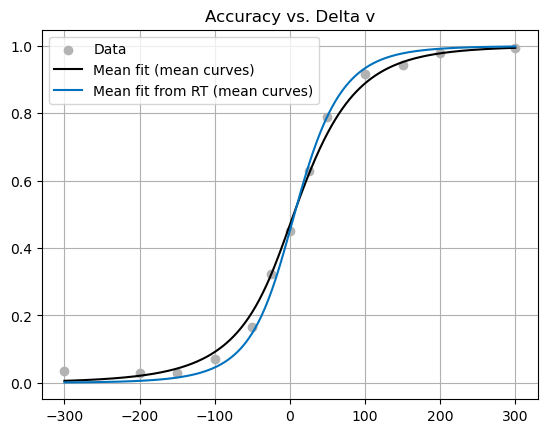

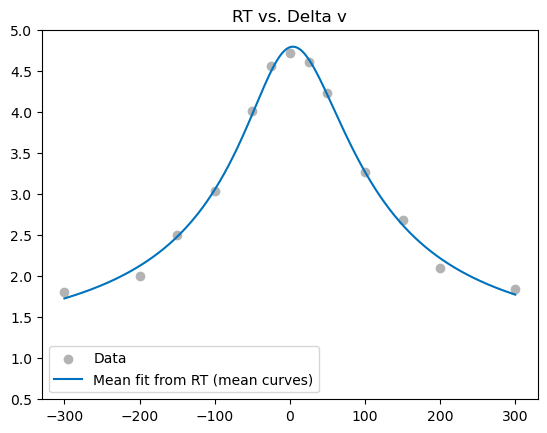

In [8]:
#Do some plotting to visualize the results
k=1.0986
aux = np.linspace(-300,300,621)
import matplotlib.pyplot as plt
fig1=plt.figure()
#First, plot average leftResponse values across the whole population, as scatter
ax1 = fig1.add_subplot(111)
mean_AC = df_excludingNR.groupby(['pertSize'])['leftResponse'].mean()
dv=mean_AC.index.to_numpy()
plt.scatter(dv, mean_AC, label = 'Data',color=(0.7,0.7,0.7))

# Initialiaze variables, all this fits do not include distraction rate parameter 
mean_y = np.zeros(len(aux))
mean_yDR = np.zeros(len(aux))
mean_y_RT = np.zeros(len(aux))

for i in data['subID'].unique():
  
  #Predictions from choice fit 
  a,b,c = params_noDR[i-1]
  y = obs_p(aux,a,b,c)
  mean_y += y
    
  #Predictions from RT fit 
  t_nd, noise_std, a, b = params_RT[i-1,:]
  y = obs_p(aux,a,b,0)
  mean_y_RT += y
  # plt.plot(aux, y, color='lightgrey')

# Average from individual curves 
mean_y_RT = mean_y_RT/n_subs
mean_y = mean_y/n_subs

# Plot the average curve for choice when fitting it to choice data
plt.plot(aux, mean_y, color='black', label='Mean fit (mean curves)')
plt.plot(aux, mean_y_RT, color=(0,0.4470,0.7410), label='Mean fit from RT (mean curves)')

#Predictions from choice fit (beta0=a/b and beta1=-1/b)
beta0=params_noDR[:,0]/params_noDR[:,1]
beta1=-1/params_noDR[:,1]

# Compute the individual JND and PSE and the distributions
JND=k/beta1
PSE=-beta0/beta1
print('Distribution of metrics across population:')
print('JND: ', np.mean(JND), ' +/- ', np.std(JND), 
      ', 95% CI: [', np.mean(JND)-1.96*np.std(JND)/np.sqrt(np.size(JND)), ',',
     np.mean(JND)+1.96*np.std(JND)/np.sqrt(np.size(JND)), ']')
print('PSE: ', np.mean(PSE), ' +/- ', np.std(PSE),
      ', 95% CI: [', np.mean(PSE)-1.96*np.std(PSE)/np.sqrt(np.size(PSE)), ',',
     np.mean(PSE)+1.96*np.std(PSE)/np.sqrt(np.size(PSE)), ']')
print('------------------------------------------')

# Predictions from RT fit
beta0_RT=params_RT[:,2]/params_RT[:,3]
beta1_RT=-1/params_RT[:,3]

# Compute the individual JND and PSE and the distributions
JND_RT=k/beta1_RT
PSE_RT=-beta0_RT/beta1_RT
print('Distribution of metrics across population using predictions from RT:')
print('JND: ', np.mean(JND_RT), ' +/- ', np.std(JND_RT), 
      ', 95% CI: [', np.mean(JND_RT)-1.96*np.std(JND_RT)/np.sqrt(np.size(JND_RT)), ',',
     np.mean(JND_RT)+1.96*np.std(JND_RT)/np.sqrt(np.size(JND_RT)), ']')
print('PSE: ', np.mean(PSE_RT), ' +/- ', np.std(PSE_RT), 
      ', 95% CI: [', np.mean(PSE_RT)-1.96*np.std(PSE_RT)/np.sqrt(np.size(PSE_RT)), ',',
     np.mean(PSE_RT)+1.96*np.std(PSE_RT)/np.sqrt(np.size(PSE_RT)), ']')
print('--------------------------------------------------------------------')

# Compute the individual JND and PSE and the distributions
TND_RT=params_RT[:,0]
NoiseSTD_RT=params_RT[:,1]
print('Distribution of metrics across population:')
print('T_nd: ', np.mean(TND_RT), ' +/- ', np.std(TND_RT), 
      ', 95% CI: [', np.mean(TND_RT)-1.96*np.std(TND_RT)/np.sqrt(np.size(TND_RT)), ',',
     np.mean(TND_RT)+1.96*np.std(TND_RT)/np.sqrt(np.size(TND_RT)), ']')
print('Noise_std: ', np.mean(NoiseSTD_RT), ' +/- ', np.std(NoiseSTD_RT),
      ', 95% CI: [', np.mean(NoiseSTD_RT)-1.96*np.std(NoiseSTD_RT)/np.sqrt(np.size(NoiseSTD_RT)), ',',
     np.mean(NoiseSTD_RT)+1.96*np.std(NoiseSTD_RT)/np.sqrt(np.size(NoiseSTD_RT)), ']')
print('------------------------------------------')

plt.title('Accuracy vs. Delta v')
plt.legend()
plt.grid()

#Now, plot RT data
fig2=plt.figure()

mean_RT = df_excludingNR.groupby(['pertSize'])['reactionTime'].mean()
plt.scatter(dv, mean_RT, label = 'Data', color=(0.7,0.7,0.7))
mean_RT_RT = np.zeros(len(aux))
for i in data['subID'].unique():
  t = df_excludingNR[df_excludingNR['subID'] == i].groupby(['pertSize'])['reactionTime'].mean()
  dv = t.index.to_numpy()
    
  # predicted RT from RT-fitted data w/o DR
  t_nd, noise_std, a, b = params_RT[i-1,:]
  RT = exp_RT(t_nd, noise_std, a, b, aux)
  mean_RT_RT += RT
  # plt.plot(aux, RT, color='lightgrey')

# Average from individual curves
mean_RT_RT = mean_RT_RT/n_subs

# Predicted RT from RT-fitted data w/o DR, curves comes from averaging individual parametes (beta0, beta1, noise, t_nd)
plt.plot(aux, mean_RT_RT, color=(0,0.4470,0.7410), label='Mean fit from RT (mean curves)') # From the averaged parameters we predict RT curve
plt.ylim(top=5)
plt.ylim(bottom=0.5)

plt.title('RT vs. Delta v')
plt.legend()

# Compare the JND and PSE between the two fits
from scipy.stats import ttest_rel

# Sample data for paired observations
# Perform the t-test
t_statistic, p_valueJND = ttest_rel(JND, JND_RT)
t_statistic, p_valuePSE = ttest_rel(PSE, PSE_RT)

# print("P-value JND:", p_valueJND)
# print("P-value PSE:", p_valuePSE)
